# 필요한 라이브러리 import

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf

warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [15]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [16]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [17]:
forward_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

# XGBoost Regressor 모델 생성

In [18]:
from xgboost import XGBRegressor,DMatrix,train,XGBRFRegressor
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold

In [61]:
forward_xgb = XGBRegressor()
parameters = {'nthread':[6], 
              'learning_rate': [0.149],
              'max_depth': [1],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'gamma':[1],
              'n_estimators': [10000]}

xgb_grid = GridSearchCV(forward_xgb,
                        parameters,
                        cv = 10,
                        scoring='neg_mean_absolute_error',
                        n_jobs = 6,
                        refit=True,
                        
                        verbose=True)

xgb_grid.fit(forward_df.loc[:,independent_value],
         forward_df.loc[:,dependent_value])

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
-0.27447917740224115
{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.149, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 10000, 'nthread': 6, 'subsample': 0.7}


In [55]:
x_train,x_test,y_train,y_test = train_test_split(fm_data_df.loc[:,independent_value],fm_data_df.loc[:,dependent_value],test_size=0.2,random_state=123)

In [65]:
forward_xgb = XGBRegressor(
    nthread=6,
    learning_rate=0.149,
    max_depth=1,
    min_child_weight=4,
    colsample_bytree = 0.8,
    gamma = 1,
    n_estimators = 10000
)

forward_xgb.fit(x_train,y_train)
y_pred = forward_xgb.predict(x_test)
mean_absolute_error(y_test,y_pred)

0.32529093465405307

# 모델검정

In [66]:
forward_df['predict'] = forward_xgb.predict(forward_df.loc[:,independent_value])

In [67]:
residual = forward_df['평균획득승점/경기'] - forward_df['predict']

## 선형성 검정

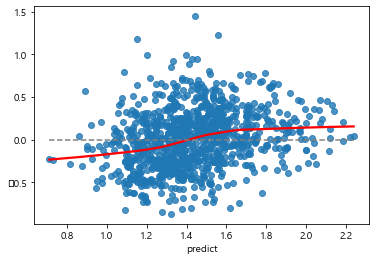

In [68]:
sns.regplot(forward_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([forward_df['predict'].values.min(), forward_df['predict'].values.max()], [0, 0], '--', color='grey')

## 잔차의 정규성 검정

In [69]:
# 정규성 불만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9951919913291931, pvalue=0.0037075523287057877)

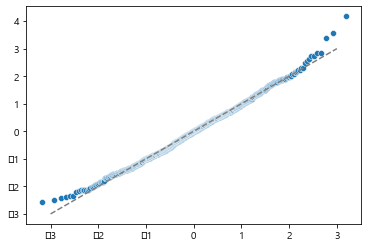

In [70]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 잔차의 등분산성 검정

<AxesSubplot:xlabel='predict'>

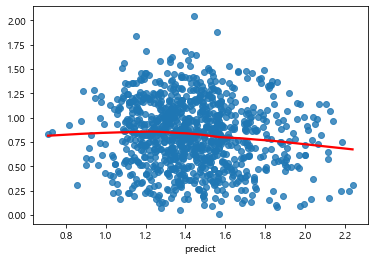

In [71]:
sns.regplot(forward_df['predict'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

In [72]:
# 등분산성 불만족
stats.levene(forward_df['평균획득승점/경기'],forward_df['predict'])

LeveneResult(statistic=387.8350035118759, pvalue=7.414362143016418e-79)

In [73]:
import joblib

joblib.dump(xgb_grid, 'forward_xgb.pkl')

['forward_xgb.pkl']